In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi
!lscpu

In [ ]:
!pip install ipyplot

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
import random
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import math
import ipyplot
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from sklearn.metrics import f1_score


        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `force_b64` param to `True`.
        


# Function Definitions

Next, we are going to define some of the functions that we are goind to need to make our code work.

In [ ]:
def decaying_cosine_annealing_scheduler(epoch):
    """
        A step rate scheduler for setting the learning rate for each epoch.
        :param epoch: current epoch
        :return: learning rate for current epoch
        """
    learning_rate_min = 1e-6
    original_learning_rate_max = 1e-3
    original_cycle_length = 15
    epochs_per_cycle = original_cycle_length-(int(epoch/original_cycle_length))
    learning_rate_max = original_learning_rate_max/((int(epoch/original_cycle_length))+1)
    #print(learning_rate_max,learning_rate_min, epoch, epochs_per_cycle)

    return learning_rate_min + (learning_rate_max - learning_rate_min) * \
           (1 + math.cos(math.pi * (epoch % epochs_per_cycle) / epochs_per_cycle)) / 2



# Loading the Data

We have saved our data and correspondng labels as a single .npy file. This is a preferred way of saving the data if the number of samples is small enough that it may fit into the system. If there are so many images that they may not fit in the system meomry all at once, then we need to read a chunk of a data at a time and process it as required.

In [ ]:
training_file_path = '/content/drive/MyDrive/train_images.npy'
training_labels_path = '/content/drive/MyDrive/train_masks.npy'
testing_file_path = '/content/drive/MyDrive/test_images.npy'
testing_labels_path = '/content/drive/MyDrive/test_masks.npy'

training_images, training_masks, testing_images, testing_masks = np.load(training_file_path), np.load(training_labels_path), np.load(testing_file_path), np.load(testing_labels_path) 

print('Shape of training images and training lables is: ', training_images.shape, ',', training_masks.shape)
print('Shape of testing images and testing lables is: ', testing_images.shape, ',', testing_masks.shape)

Shape of training images and training lables is:  (762, 256, 256, 3) , (762, 256, 256)
Shape of teting images and testing lables is:  (76, 256, 256, 3) , (76, 256, 256)


# Visualising the Data

We can quickly visualise a couple of images to check what the data looks like. We are also going to visualise the labels as well. The labels here are stored as one-hot encoding.


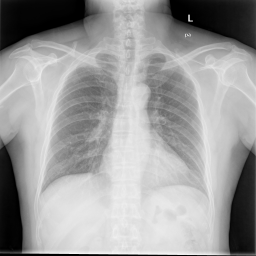
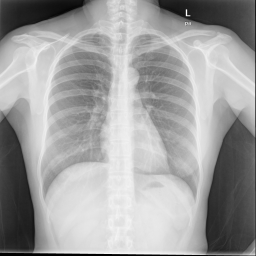
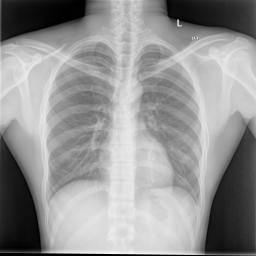
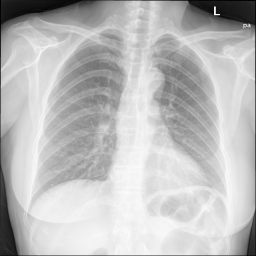
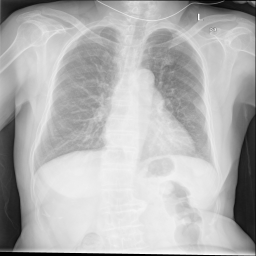
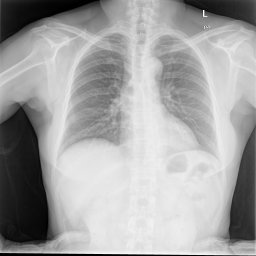
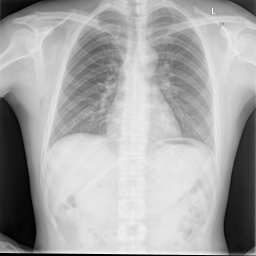
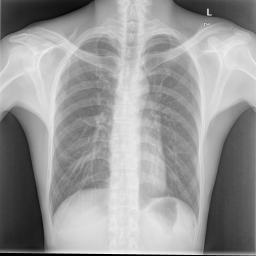
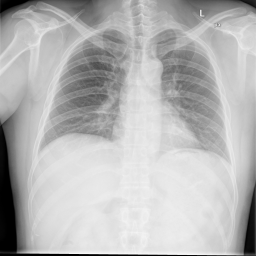
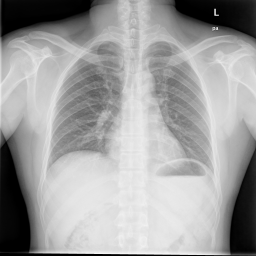


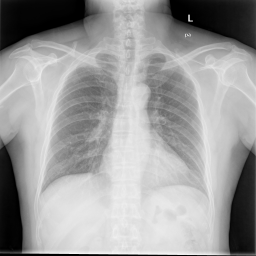
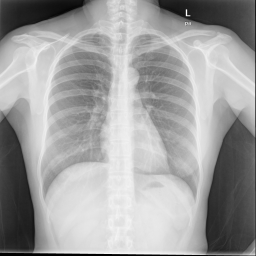
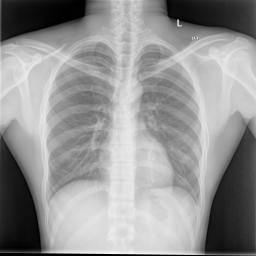
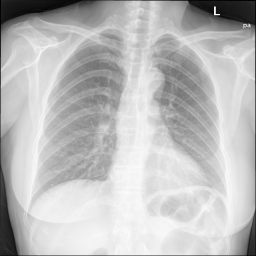
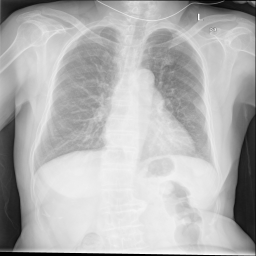
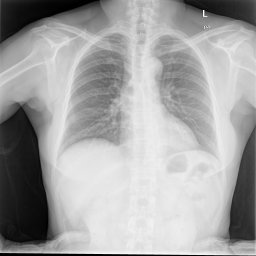
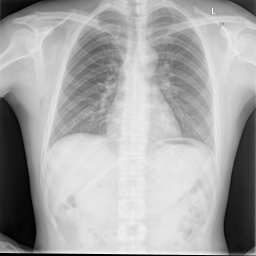
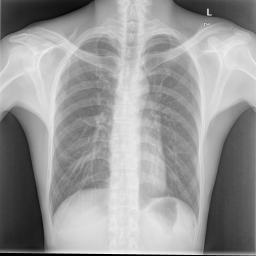
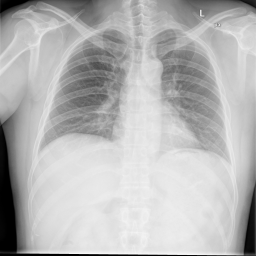
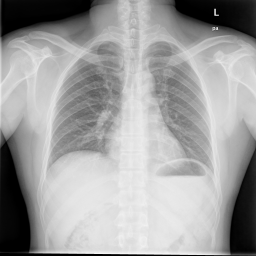


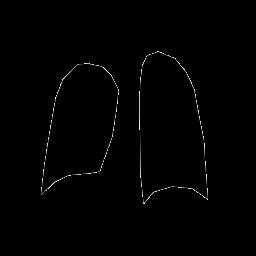
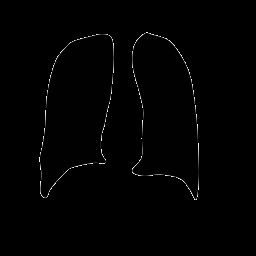
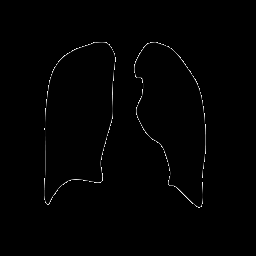
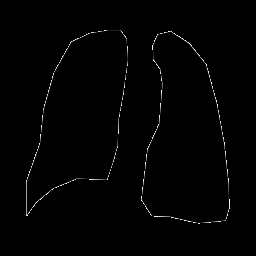
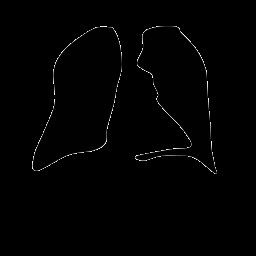
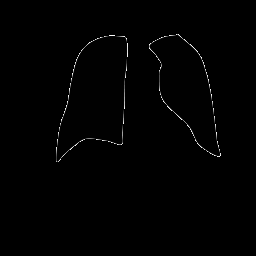
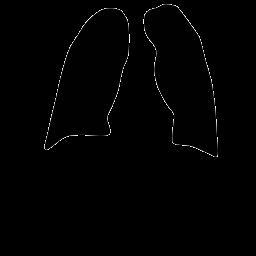
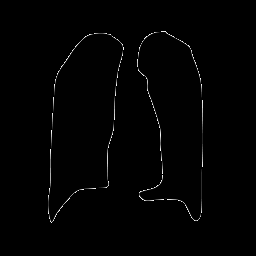
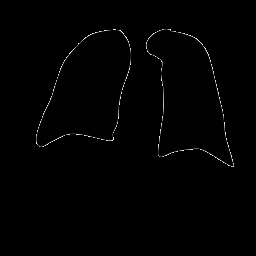
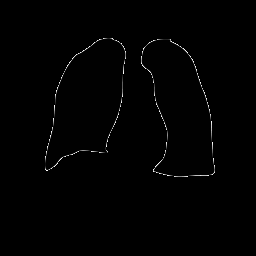


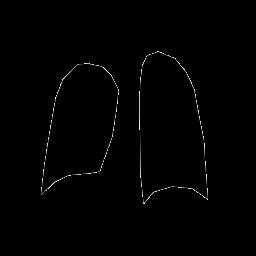
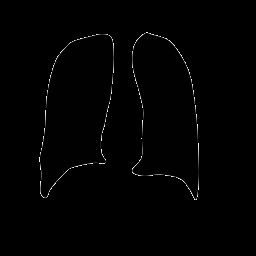
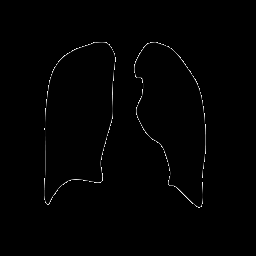
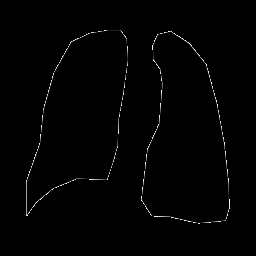
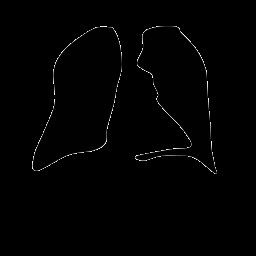
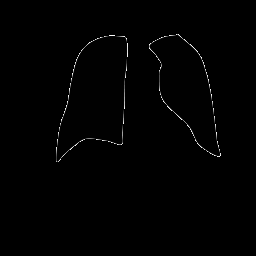
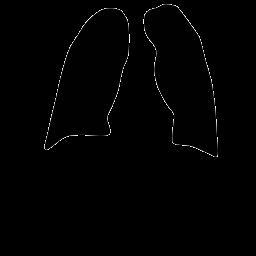
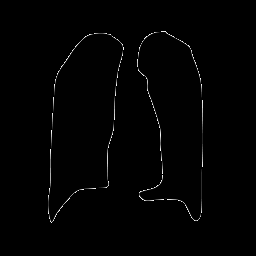
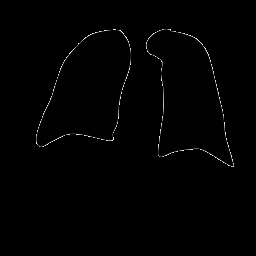
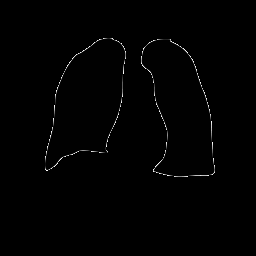

In [ ]:
ipyplot.plot_images(training_images[:,:,:,::-1], max_images=10, img_width=150)
ipyplot.plot_images(training_masks*255, max_images=10, img_width=150)


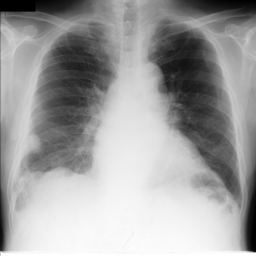
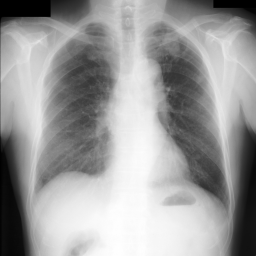
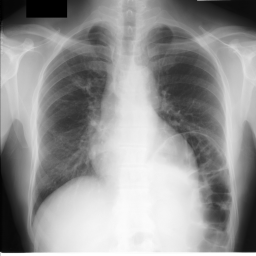
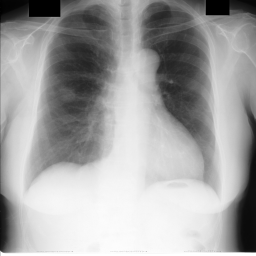
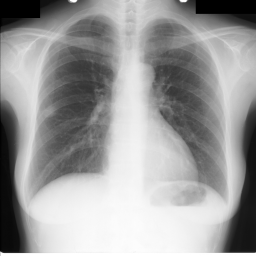
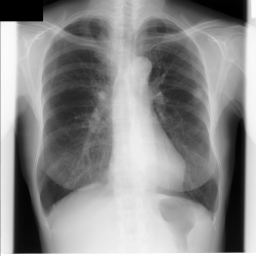
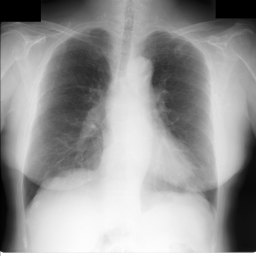
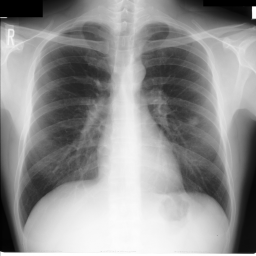
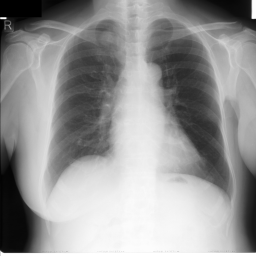
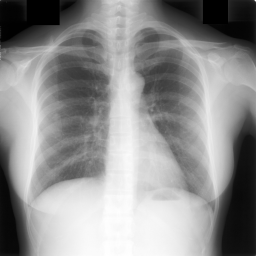


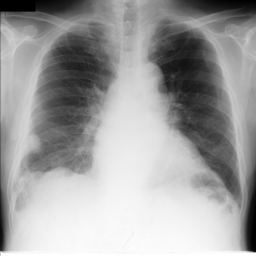
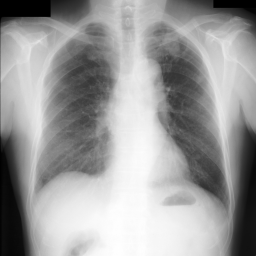
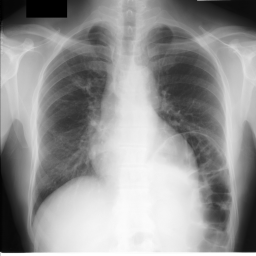
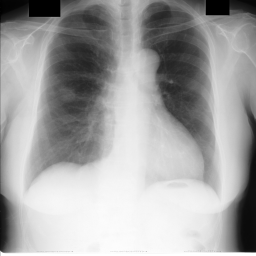
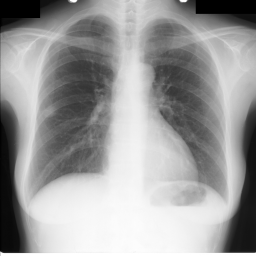
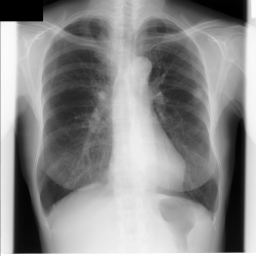
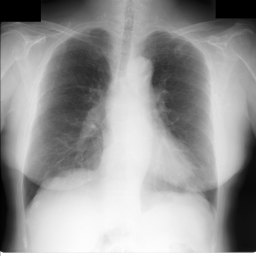
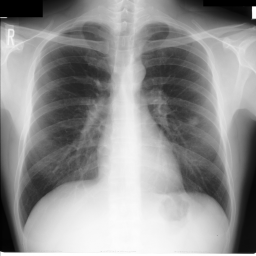
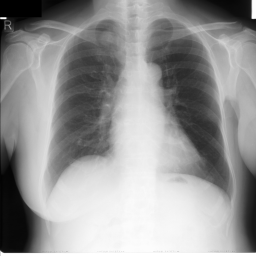
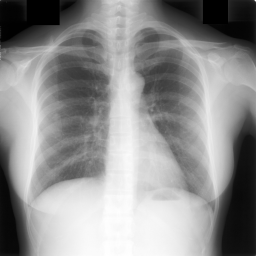


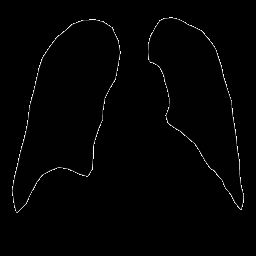
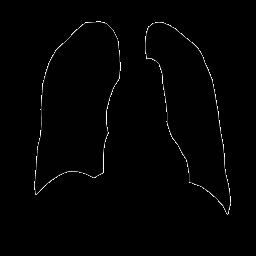
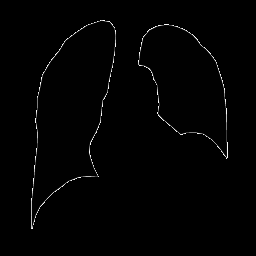
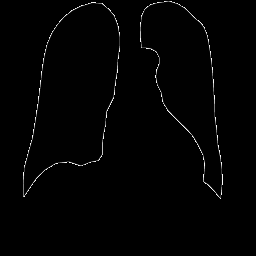
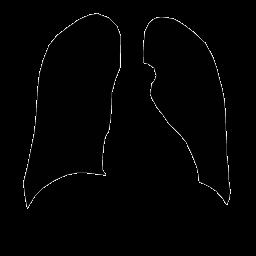
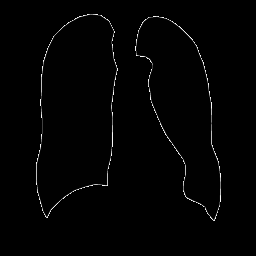
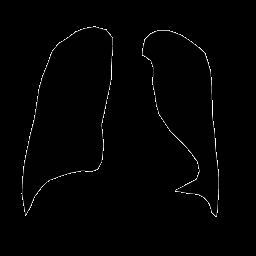
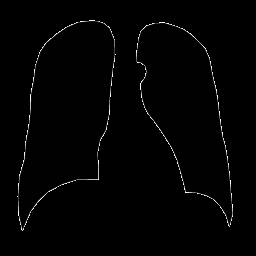
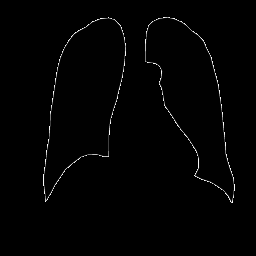
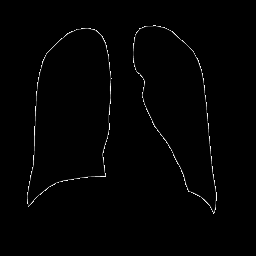


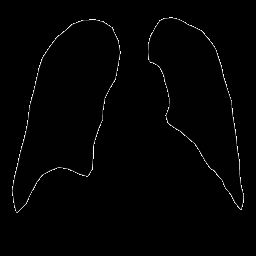
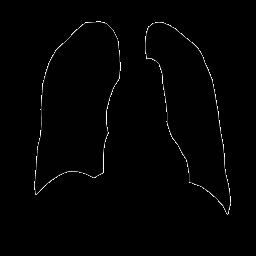
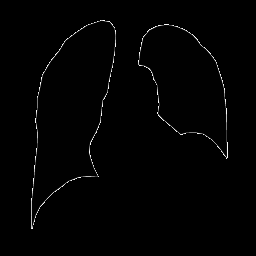
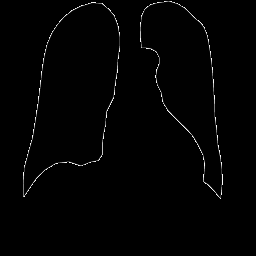
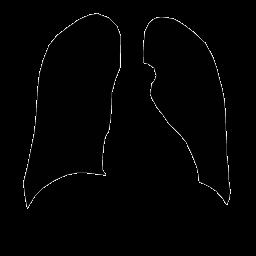
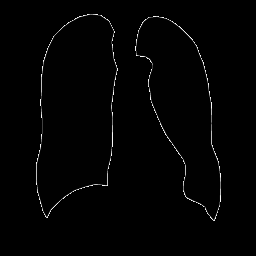
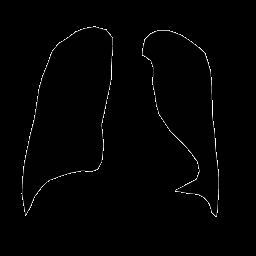
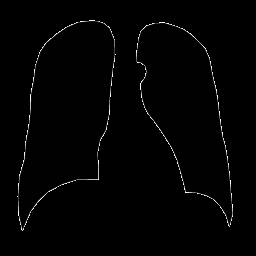
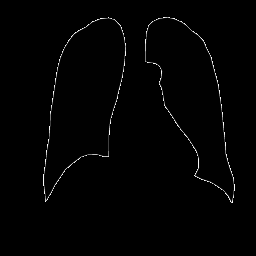
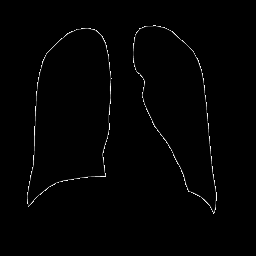

In [ ]:
ipyplot.plot_images(testing_images[:,:,:,::-1], max_images=10, img_width=150)
ipyplot.plot_images(testing_masks*255, max_images=10, img_width=150)

# Defining the Architecture

Now we are going to create the LWNet architecture and then we are going to compile it.

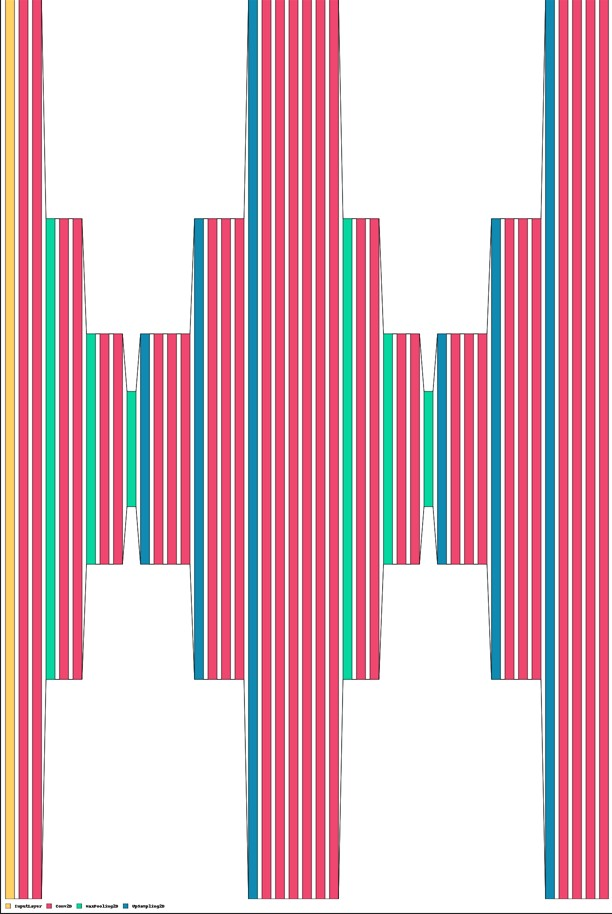

In [ ]:
inputs = Input((256,256,3))

#Size at the end of conv = (256,256,8)
conv1 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
conv1 = BatchNormalization()(conv1)
conv1 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
batch1 = BatchNormalization()(conv1)
drop1 = Dropout(0.25)(batch1)
pool1 = MaxPooling2D(pool_size=(2, 2))(drop1)

#Size at the end of conv = (128,128,16)
conv2 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
batch2 = BatchNormalization()(conv2)
drop2 = Dropout(0.25)(batch2)
pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)

#Size at the end of conv = (64,64,32)
conv3 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
batch3 = BatchNormalization()(conv3)
drop3 = Dropout(0.25)(batch3)
pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)
###############Downsampling ends here#############################


##############Upsampling starts here##############################
#Size = (128,128,16)
up4 = (UpSampling2D(size=(2, 2))(pool3))
up4 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up4)
up4 = BatchNormalization()(up4)
merge4 = concatenate([drop3, up4], axis=3)
conv4 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge4)
conv4 = BatchNormalization()(conv4)
conv4 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
conv4 = BatchNormalization()(conv4)

#Size = (256,256,8)
up7 = (UpSampling2D(size=(2, 2))(conv4))
up7 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up7)
up7 = BatchNormalization()(up7)
merge7 = concatenate([drop2, up7], axis=3)
conv7 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
conv7 = BatchNormalization()(conv7)
conv7 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
conv7 = BatchNormalization()(conv7)

#Size = (512,512,1)
up8 = (UpSampling2D(size=(2, 2))(conv7))
up8 = Conv2D(1, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up8)
up8 = BatchNormalization()(up8)
merge8 = concatenate([drop1, up8], axis=3)
conv8 = Conv2D(1, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
conv8 = BatchNormalization()(conv8)
conv8 = Conv2D(1, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
conv8 = BatchNormalization()(conv8)

conv10 = Conv2D(1, 1, activation='sigmoid')(conv8)
#######################################################################################################################
#######################################################################################################################


attn_map = concatenate([conv10, inputs], axis=3)

#Size = (256,256,8)
conv11 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(attn_map)
conv11 = BatchNormalization()(conv11)
conv11 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv11)
batch11 = BatchNormalization()(conv11)
drop11 = Dropout(0.25)(batch11)
pool11 = MaxPooling2D(pool_size=(2, 2))(drop11)

#Size = (128,128,16)
conv12 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool11)
conv12 = BatchNormalization()(conv12)
conv12 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv12)
batch12 = BatchNormalization()(conv12)
drop12 = Dropout(0.25)(batch12)
pool12 = MaxPooling2D(pool_size=(2, 2))(drop12)

#Size = (64,64,32)
conv13 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool12)
conv13 = BatchNormalization()(conv13)
conv13 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv13)
batch13 = BatchNormalization()(conv13)
drop13 = Dropout(0.25)(batch13)
pool13 = MaxPooling2D(pool_size=(2, 2))(drop13)
###############Downsampling ends here#############################


##############Upsampling starts here##############################
#Size = (128,128,16)
up14 = (UpSampling2D(size=(2, 2))(pool13))
up14 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up14)
up14 = BatchNormalization()(up14)
merge14 = concatenate([drop13, up14], axis=3)
conv14 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge14)
conv14 = BatchNormalization()(conv14)
conv14 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv14)
conv14 = BatchNormalization()(conv14)

#Size = (256,256,8)
up17 = (UpSampling2D(size=(2, 2))(conv14))
up17 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up17)
up17 = BatchNormalization()(up17)
merge17 = concatenate([drop12, up17], axis=3)
conv17 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge17)
conv17 = BatchNormalization()(conv17)
conv17 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv17)
conv17 = BatchNormalization()(conv17)

#Size = (512,512,1)
up18 = (UpSampling2D(size=(2, 2))(conv17))
up18 = Conv2D(1, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up18)
up18 = BatchNormalization()(up18)
merge18 = concatenate([drop11, up18], axis=3)
conv18 = Conv2D(1, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge18)
conv18 = BatchNormalization()(conv18)
conv18 = Conv2D(1, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv18)
conv18 = BatchNormalization()(conv18)

conv20 = Conv2D(1, 1, activation='sigmoid')(conv18)


my_model = Model(inputs=inputs, outputs=[conv10, conv20])

my_model.compile(optimizer=Adam(lr=1e-4), loss=[BinaryCrossentropy(), BinaryCrossentropy()],
                 loss_weights=[0.5,0.5], metrics=['binary_accuracy'])

my_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  224         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 ormalization)                                                                                    
                                                                                                  
 conv2d_14 (Conv2D)             (None, 256, 256, 1)  10          ['batch_normalization_13[0][0]'] 
                                                                                                  
 batch_normalization_14 (BatchN  (None, 256, 256, 1)  4          ['conv2d_14[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_15 (Conv2D)             (None, 256, 256, 1)  2           ['batch_normalization_14[0][0]'] 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 256, 256, 4)  0           ['conv2d_15[0][0]',              
          

# Defining Callbacks

Callbacks allow us to control different aspects of the training phase. We can specify when a model should be saved during the training phase, how often the learning rate must be changed and whether any logs in the form of text or any other files should be maintined. There are also other callbacks as well that provide some different functionality.

In [ ]:
major_revision, minor_revision = 2,2
model_save_path = '/content/drive/MyDrive/Demo_Data/models/'
log_save_path = '/content/drive/MyDrive/logs/'

file_path = os.path.join(model_save_path, 'm%i-%i.h5' % (major_revision, minor_revision))
checkpoints_callback = tf.keras.callbacks.ModelCheckpoint(file_path, monitor= 'conv2d_31_binary_accuracy', verbose = 1, mode='max', save_best_only=True, save_freq='epoch')
    
learning_rate_callback = tf.keras.callbacks.LearningRateScheduler(decaying_cosine_annealing_scheduler, verbose=True)
    
file = open(os.path.join(log_save_path, 'log-%i-%i.txt' % (major_revision, minor_revision)),'a+')
    
text_logging_callback = tf.keras.callbacks.LambdaCallback(
on_epoch_end=lambda epoch, logs: file.write('####EPOCH %i\n' % (epoch + 1) + '#### VALIDATION ACCURACY =%.5f \n' % logs['conv2d_31_binary_accuracy'])
)
    
my_callbacks = [checkpoints_callback, learning_rate_callback, text_logging_callback]

# Training the Model

Now we are going to train our model using the model.fit() function.

In [ ]:
epochs = 100

print('Training...')

my_model_history = my_model.fit(x=training_images, y=training_masks, epochs=epochs, validation_split = 0.1)


file.close()

Training...
Epoch 1/100
22/22 [==============================] - 7s 305ms/step - loss: -1030.3232 - conv2d_47_loss: -1030.4526 - conv2d_63_loss: -1030.1938 - conv2d_47_binary_accuracy: 0.3230 - conv2d_63_binary_accuracy: 1.5963e-04 - val_loss: -847.6179 - val_conv2d_47_loss: -984.3329 - val_conv2d_63_loss: -710.9031 - val_conv2d_47_binary_accuracy: 0.3291 - val_conv2d_63_binary_accuracy: 1.6170e-04
Epoch 2/100
22/22 [==============================] - 7s 306ms/step - loss: -1030.3652 - conv2d_47_loss: -1030.5854 - conv2d_63_loss: -1030.1447 - conv2d_47_binary_accuracy: 0.2775 - conv2d_63_binary_accuracy: 1.5963e-04 - val_loss: -965.7192 - val_conv2d_47_loss: -984.6566 - val_conv2d_63_loss: -946.7819 - val_conv2d_47_binary_accuracy: 0.3423 - val_conv2d_63_binary_accuracy: 1.6170e-04
Epoch 3/100
22/22 [==============================] - 7s 310ms/step - loss: -1030.6544 - conv2d_47_loss: -1030.7578 - conv2d_63_loss: -1030.5510 - conv2d_47_binary_accuracy: 0.3342 - conv2d_63_binary_accuracy:

# Gauging the Performance

Now that we have trained our model, we need to figure our how good the model actually is. One of the ways to do that is to use a confusion matrix. Simply, put, the confusion matrix is a representation of how well our model is performing for all the classes and for each class as well.

We need to pass our testing images through the model first in order to obtain the confusion matrix.

(2, 76, 256, 256, 1)
(76, 256, 256, 1)
(76, 256, 256)
(76, 256, 256) (76, 256, 256)



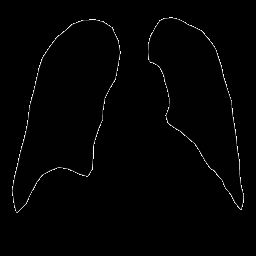
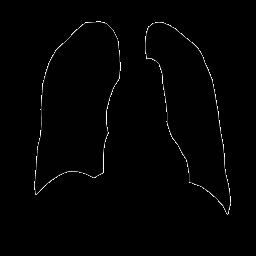
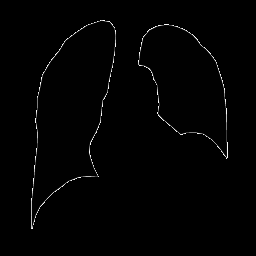
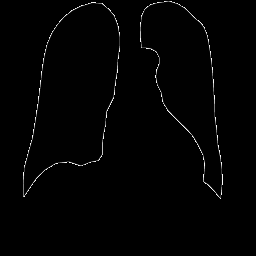
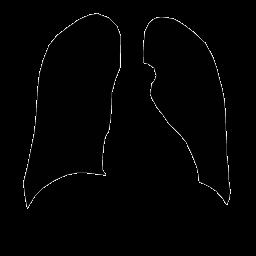
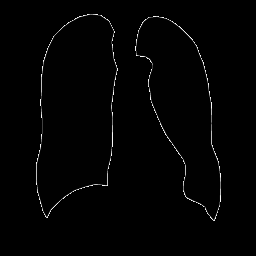
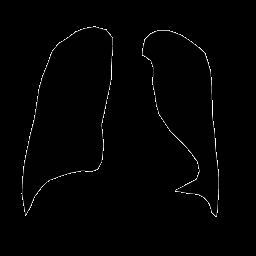
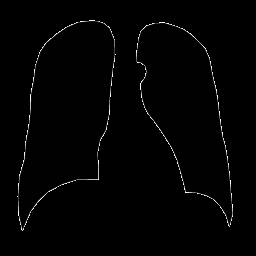
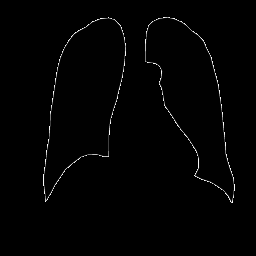
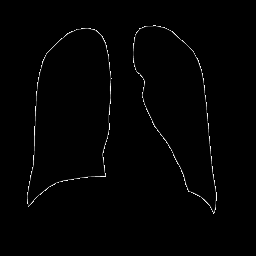


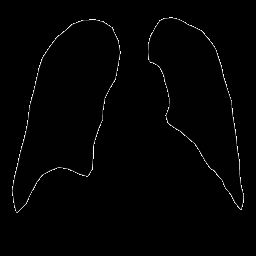
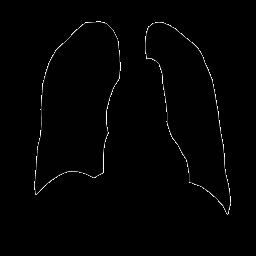
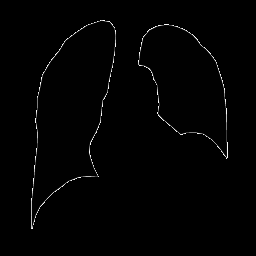
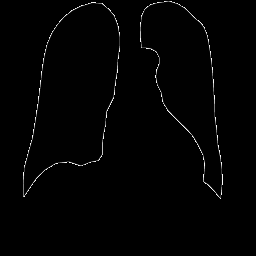
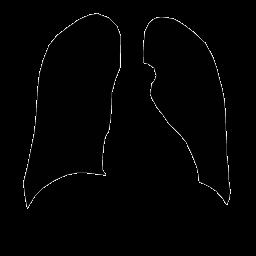
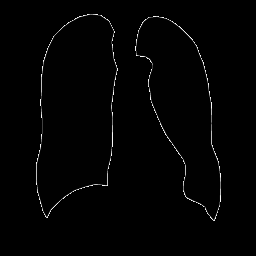
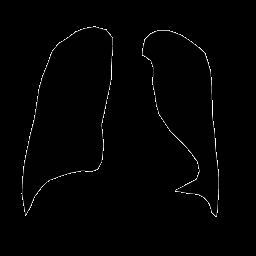
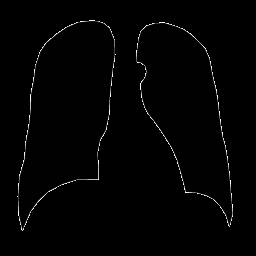
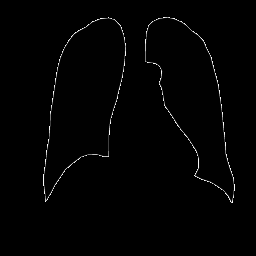
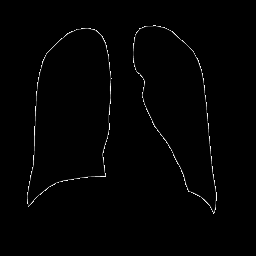


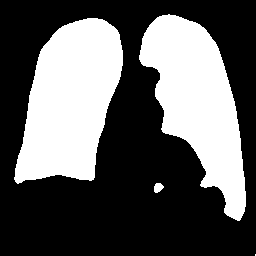
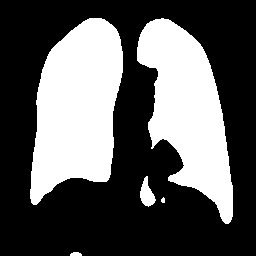
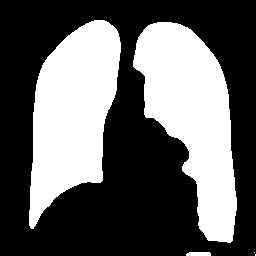
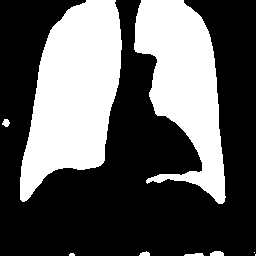
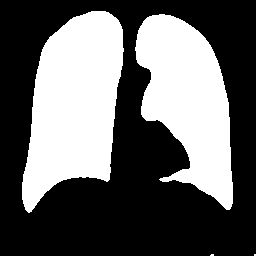
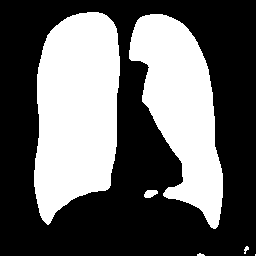
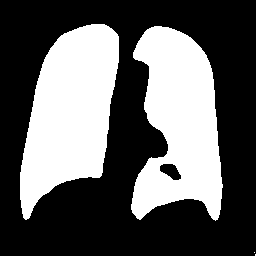
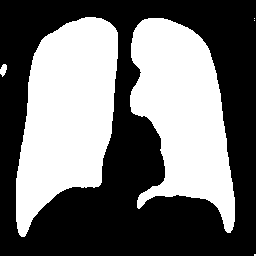
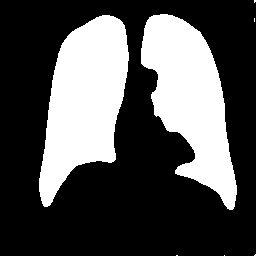
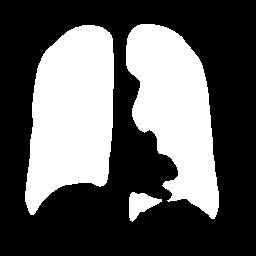


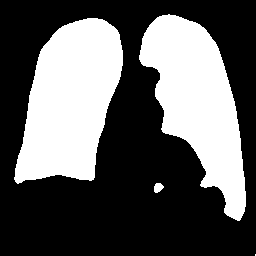
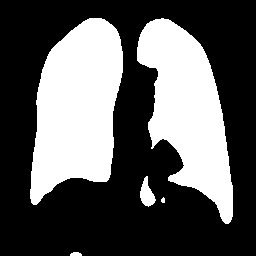
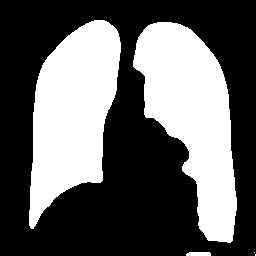
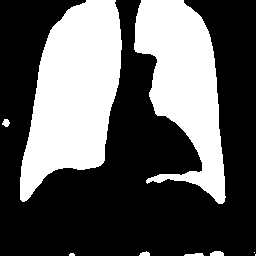
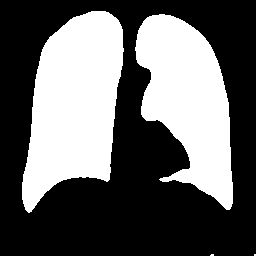
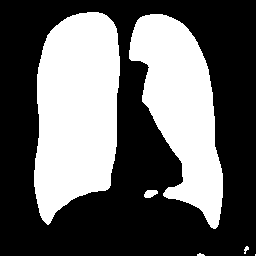
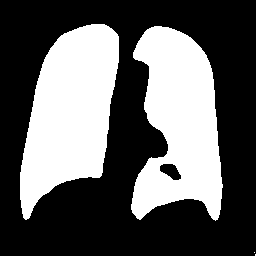
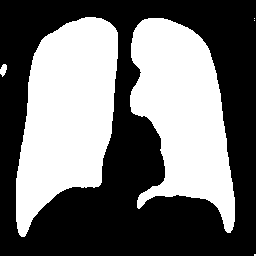
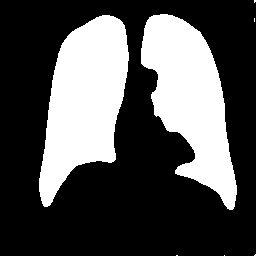
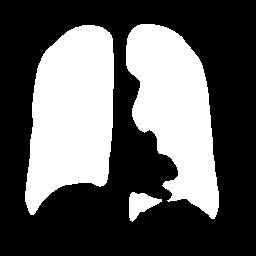

F1 score:  [9.41985694e-01 2.94130750e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+

In [ ]:
my_predictions = my_model.predict(testing_images)

print(np.shape(my_predictions))

my_predictions = my_predictions[-1]

print(my_predictions.shape)


my_predictions = np.asarray(my_predictions*255).astype(np.uint8).reshape(76,256,256)
print(my_predictions.shape)


for i in range(len(my_predictions)):
  my_predictions[i,...] = cv2.threshold(my_predictions[i,...].reshape(256,256), 0, 1, cv2.THRESH_OTSU)[1]



ground_truths_masks = np.asarray(testing_masks, dtype=np.uint8)
my_predictions = np.asarray(my_predictions, dtype=np.uint8)

print(np.shape(ground_truths_masks), np.shape(my_predictions))

ipyplot.plot_images(testing_masks*255, max_images=10, img_width=150)
ipyplot.plot_images(my_predictions*255, max_images=10, img_width=150)

my_predictions = my_predictions.reshape(my_predictions.shape[0] * my_predictions.shape[1] * my_predictions.shape[2],1)
ground_truths_masks = ground_truths_masks.reshape(ground_truths_masks.shape[0] * ground_truths_masks.shape[1]
                                                  * ground_truths_masks.shape[2],1)
validation_accuracy = f1_score(ground_truths_masks, my_predictions, average=None)

print('F1 score: ', validation_accuracy)